In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset_path = '/content/drive/MyDrive/QBIO 465 FP/Original'
# model_path = '/content/drive/MyDrive/QBIO 465 FP/basic_cnn_seq_model.h5'

dataset_path = '/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/Original'
model_path = '/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/basic_cnn_seq_model.h5'

classes = ['Benign', 'Early', 'Pre', 'Pro']
class_labels = np.array(classes)

In [ ]:
#

def simple_preprocess(img):
    if img.dtype != np.float32:
        img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)


In [ ]:
cnn = load_model(model_path)

cnn.layers[-1].activation = tf.keras.activations.linear


input_tensor = Input(shape=(224, 224, 3), name="gradcam_input")
x = input_tensor
for layer in cnn.layers:
    x = layer.__class__.from_config(layer.get_config())(x)

functional_model = Model(inputs=input_tensor, outputs=x)

last_conv_layer_name = None
for layer in functional_model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"Using last conv layer: {last_conv_layer_name}")

Using last conv layer: conv2d_2


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow import keras
from PIL import Image
from IPython.display import display, Image as IPyImage
import os


In [ ]:
"""
Algorithm adapted from: https://keras.io/examples/vision/grad_cam/
"""

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
             pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    grads = tape.gradient(class_output, conv_outputs)

     # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

     # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def overlay_gradcam(original_img, heatmap, alpha=0.4):


    if original_img.dtype == np.uint8:
        original_img = original_img.astype('float32') / 255.0

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Create an image with RGB colorized heatmap
    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match original image
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap) / 255.0  # Back to float32 [0,1]

    # Superimpose the heatmap on original image
    superimposed_img = alpha * jet_heatmap + (1 - alpha) * original_img


    return np.clip(superimposed_img, 0, 1)

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
import tensorflow as tf

def load_sequential_model(model_path):
    return load_model(model_path)


def convert_functional_model(seq_model):
    # Remove softmax
    seq_model.layers[-1].activation = tf.keras.activations.linear

    input_tensor = Input(shape=seq_model.input_shape[1:], name="gradcam_input")
    x = input_tensor
    new_layers = []
    for layer in seq_model.layers:
        new_layer = layer.__class__.from_config(layer.get_config())
        new_layers.append(new_layer)
        x = new_layer(x)

    functional_model = Model(inputs=input_tensor, outputs=x)

    for new_layer, old_layer in zip(new_layers, seq_model.layers):
        new_layer.set_weights(old_layer.get_weights())

    return functional_model



def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None


In [ ]:
def generate_gradcam_cnn(model, model_name, image_indices, dataset_path, class_labels,
                         preprocess_func, last_conv_layer_name, img_size=(224, 224)):

    image_paths, labels = [], []
    for cls in class_labels:
        folder = os.path.join(dataset_path, cls)
        for fname in sorted(os.listdir(folder)):
            if fname.endswith('.jpg') and not fname.startswith('aug_'):
                image_paths.append(os.path.join(folder, fname))
                labels.append(cls)

    functional_model = convert_functional_model(model)

    gradcam_last_conv_layer = last_conv_layer_name

    from collections import defaultdict
    class_to_indices = defaultdict(list)
    for idx in image_indices:
        class_to_indices[labels[idx]].append(idx)

    max_rows = max(len(idxs) for idxs in class_to_indices.values())
    fig, axs = plt.subplots(max_rows, len(class_labels), figsize=(3 * len(class_labels), 3 * max_rows))
    axs = np.atleast_2d(axs)

    for col, cls in enumerate(class_labels):
        for row in range(max_rows):
            ax = axs[row, col]
            if row < len(class_to_indices[cls]):
                idx = class_to_indices[cls][row]
                path = image_paths[idx]
                true_label = labels[idx]


                img = Image.open(path).resize(img_size).convert('RGB')
                img_array = np.array(img)
                input_tensor = preprocess_func(img_array)


                preds = model.predict(input_tensor, verbose=0)
                pred_index = tf.argmax(preds[0]).numpy()
                pred_label = class_labels[pred_index]

                print(f"[DEBUG] Idx: {idx} | True: {true_label} | Pred: {pred_label} | Raw: {preds[0]}")

                heatmap = make_gradcam_heatmap(input_tensor, functional_model, gradcam_last_conv_layer, pred_index)
                overlay = overlay_gradcam(img_array, heatmap)

                ax.imshow(overlay)
                ax.set_title(f"Idx: {idx}\nTrue: {true_label}\nPred: {pred_label}", fontsize=8)
            ax.axis('off')


    plt.suptitle(f"Grad-CAM Grid – {model_name}", fontsize=14, y=1.02)
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5, rect=[0, 0, 1, 0.95])
    plt.show()

    plt.show()


[DEBUG] Idx: 83 | True: Benign | Pred: Benign | Raw: [25.803541  -9.1936455 -2.9025335 -1.2418181]
[DEBUG] Idx: 305 | True: Benign | Pred: Pre | Raw: [ -0.39235252   4.6230087    7.672035   -14.262918  ]
[DEBUG] Idx: 341 | True: Benign | Pred: Early | Raw: [ 10.783831   10.88159    -4.5203547 -15.052389 ]
[DEBUG] Idx: 117 | True: Benign | Pred: Benign | Raw: [ 37.47614   -2.140666   5.459045 -24.144451]
[DEBUG] Idx: 1149 | True: Early | Pred: Early | Raw: [  8.643811   13.018022   -1.8787959 -17.203243 ]
[DEBUG] Idx: 1403 | True: Early | Pred: Early | Raw: [  2.9045842  17.256351    7.8259525 -26.169117 ]
[DEBUG] Idx: 1281 | True: Early | Pred: Early | Raw: [ 12.089307   30.155706   -2.4135432 -39.567234 ]
[DEBUG] Idx: 1361 | True: Early | Pred: Early | Raw: [  6.234909   18.042812    3.2790744 -28.980947 ]
[DEBUG] Idx: 1759 | True: Pre | Pred: Pre | Raw: [-4.8164196 -1.9904094  5.274854  -4.6631494]
[DEBUG] Idx: 1913 | True: Pre | Pred: Pre | Raw: [  9.588064 -17.261597  40.172825 -24

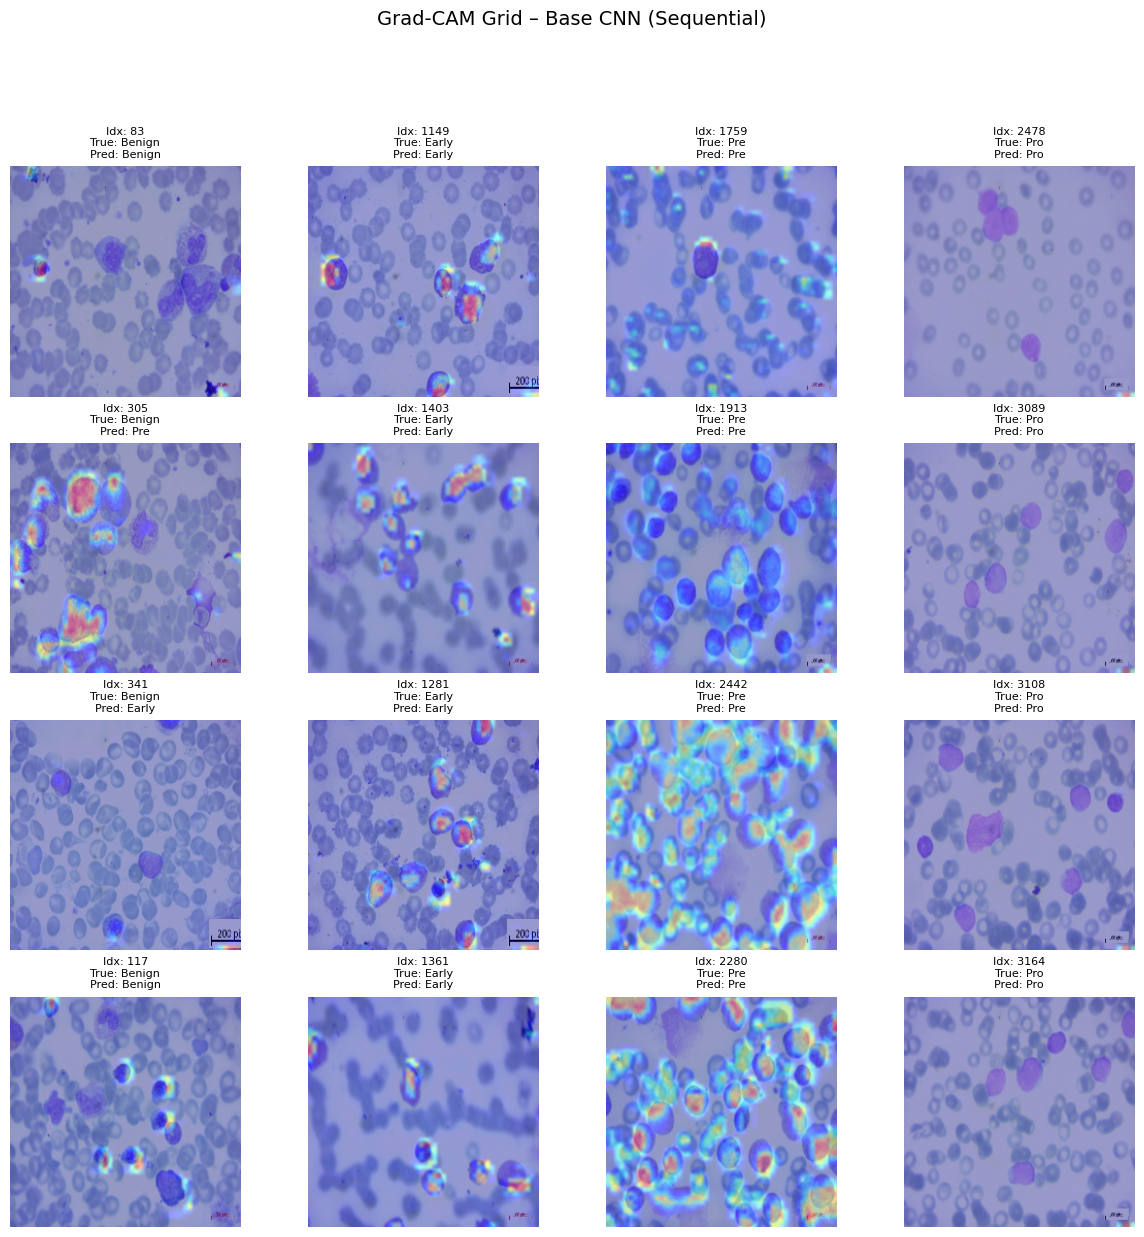

In [ ]:
shared_indices = [
    83, 305, 341, 117,
    1149, 1403, 1281, 1361,
    1759, 1913, 2442, 2280,
    2478, 3089, 3108, 3164
]

seq_model = load_sequential_model(model_path)
functional_model = convert_to_functional_model_without_softmax(seq_model)
last_conv_layer_name = get_last_conv_layer_name(functional_model)

generate_gradcam_cnn(
    model=seq_model,
    model_name='Base CNN (Sequential)',
    image_indices=shared_indices,
    dataset_path=dataset_path,
    class_labels=classes,
    preprocess_func=simple_preprocess,
    last_conv_layer_name=last_conv_layer_name
)


In [ ]:
cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,478 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)